# Forecast Ghana GDP

Import dependencies.

In [60]:
import numpy as np
import pandas as pd
import pmdarima as pm
import warnings

from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from urllib3.exceptions import NotOpenSSLWarning

warnings.simplefilter(action='ignore', category=NotOpenSSLWarning)
warnings.simplefilter(action='ignore', category=UserWarning)


### Load and visualize data

Load data.

In [61]:
data = pd.read_csv('../../data/Task10_ghana_gdp.csv', index_col='year', parse_dates=['year'])
data

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


Visualize the original time series.

<Axes: title={'center': 'Ghana GDP in USD'}, xlabel='year'>

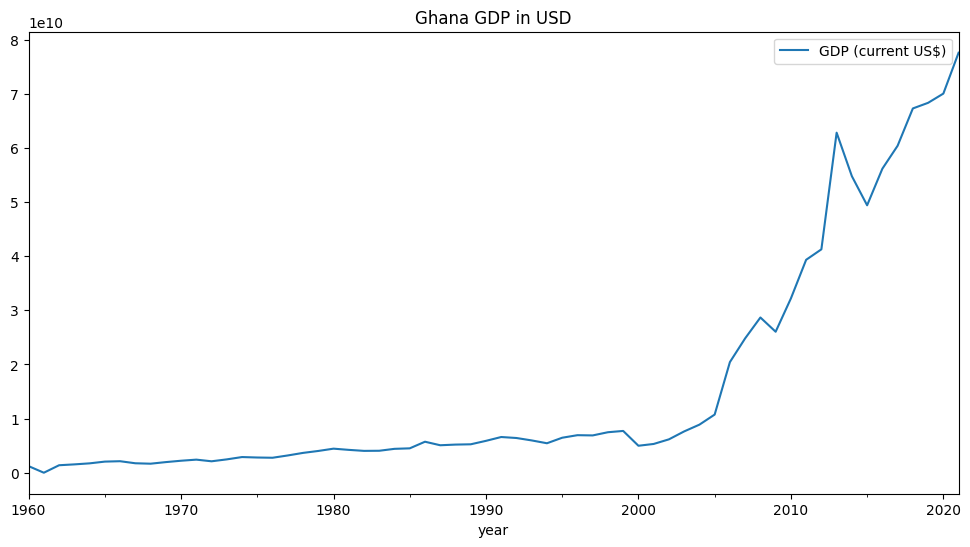

In [62]:
data.plot(
    figsize=(12,6),
    title='Ghana GDP in USD'
)

Perform and visualize a seasonal decomposition.

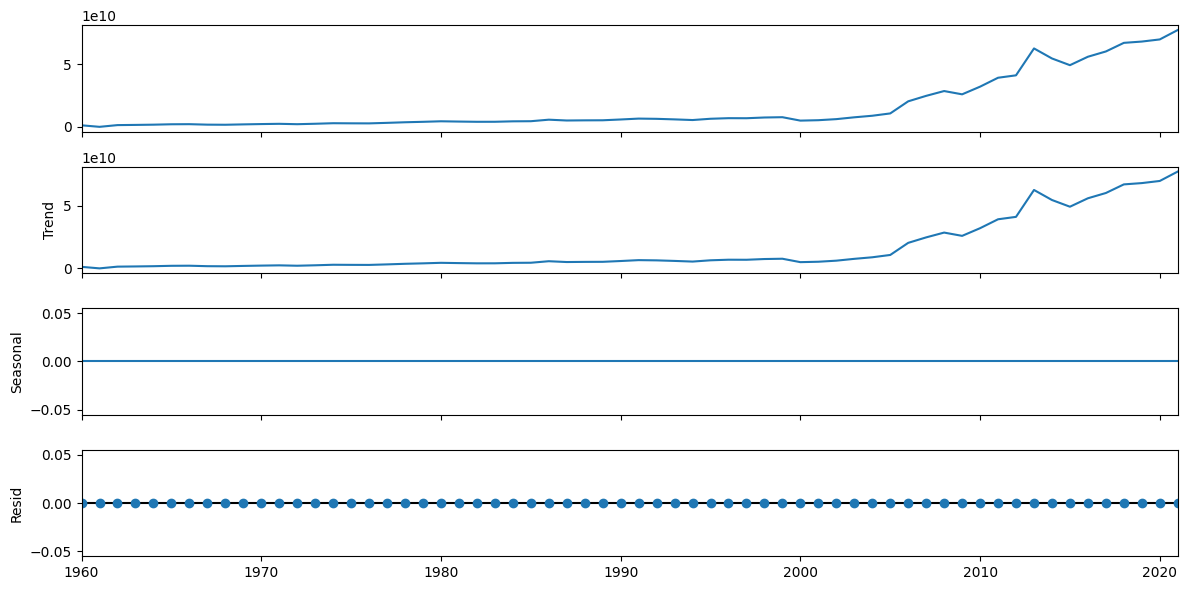

In [63]:
plt.rcParams['figure.figsize'] = 12, 6

decomposition = seasonal_decompose(data)
decomposition.plot()
plt.show()


There is a slight upwards trend since 2000.

There is no seasonality.

## Modelling with Raw Data

### Split Train and Test Data

In [64]:
# Take the years up to 2018 as train data. The remaining three years are taken as test data.
data_train = data[:-3]
data_test = data[-3:]

### Moving average

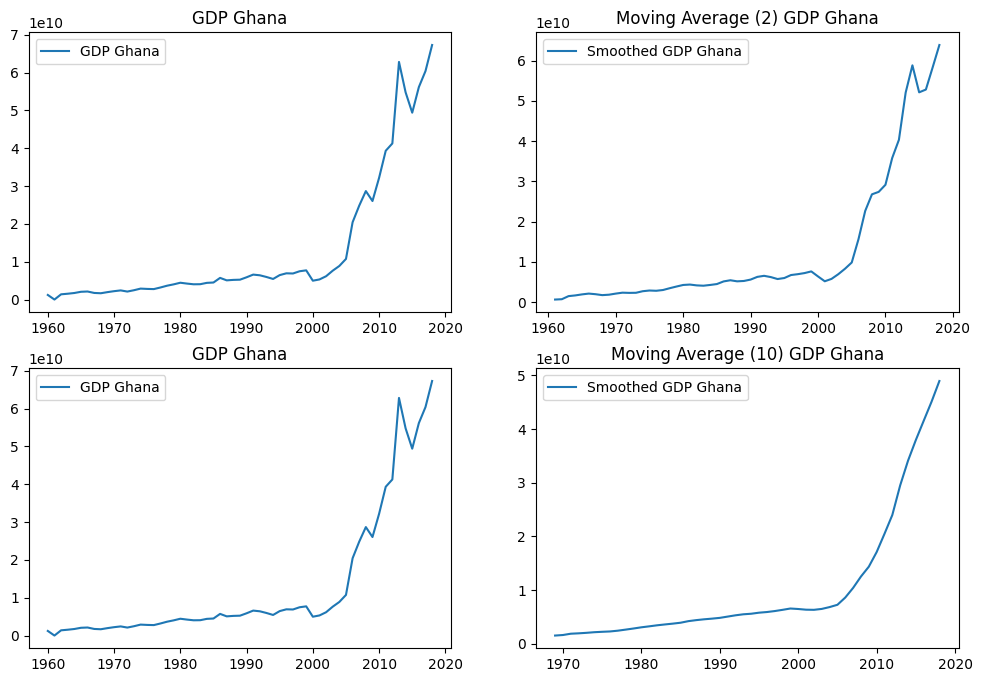

In [65]:
plt.rcParams['figure.figsize'] = 12, 8

fig, ax = plt.subplots(2, 2)

ax[0, 0].plot(data_train['GDP (current US$)'], label='GDP Ghana')
ax[0, 0].set_title('GDP Ghana')
ax[0, 0].legend()

ax[0, 1].plot(data_train['GDP (current US$)'].rolling(window=2).mean(), label='Smoothed GDP Ghana')
ax[0, 1].set_title('Moving Average (2) GDP Ghana')
ax[0, 1].legend()

ax[1, 0].plot(data_train['GDP (current US$)'], label='GDP Ghana')
ax[1, 0].set_title('GDP Ghana')
ax[1, 0].legend()

ax[1, 1].plot(data_train['GDP (current US$)'].rolling(window=10).mean(), label='Smoothed GDP Ghana')
ax[1, 1].set_title('Moving Average (10) GDP Ghana')
ax[1, 1].legend()

The oveall upwards trend after the year 2000 was clear on the original data. With moving average and the window equal to 10 it is unambiguous.

### Stationarity and ARMA/ARIMA models

Check if a time series is stationary using the Dickey-Fuller method.

In [66]:
def do_adfuller(df):
    result = adfuller(df['GDP (current US$)'])

    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value:.3f}")

do_adfuller(data_train)

ADF Statistic: 0.6529066974885374
p-value: 0.9888496277665573
Critical Values:
	1%: -3.575
	5%: -2.924
	10%: -2.600


The statistics are higher than any of the critical values. We will differentiate the data and try again.

In [67]:
do_adfuller(data_train.diff().dropna())

ADF Statistic: -1.670248303832079
p-value: 0.4465029329713883
Critical Values:
	1%: -3.568
	5%: -2.921
	10%: -2.599


The statistics are still higher that any of the critical values. We will differentiate the data twice and try again.

In [68]:
do_adfuller(data_train.diff(2).dropna())

ADF Statistic: -3.5836708658260332
p-value: 0.00608098975387688
Critical Values:
	1%: -3.585
	5%: -2.928
	10%: -2.602


After differentiating the data twice we get a stationary time series. This means that the parameter d for ARIMA is equal to 2.

### Autocorrelation and partial autocorrelation

We proceed with building correlograms for autocorrelation and partial autocorrelation.

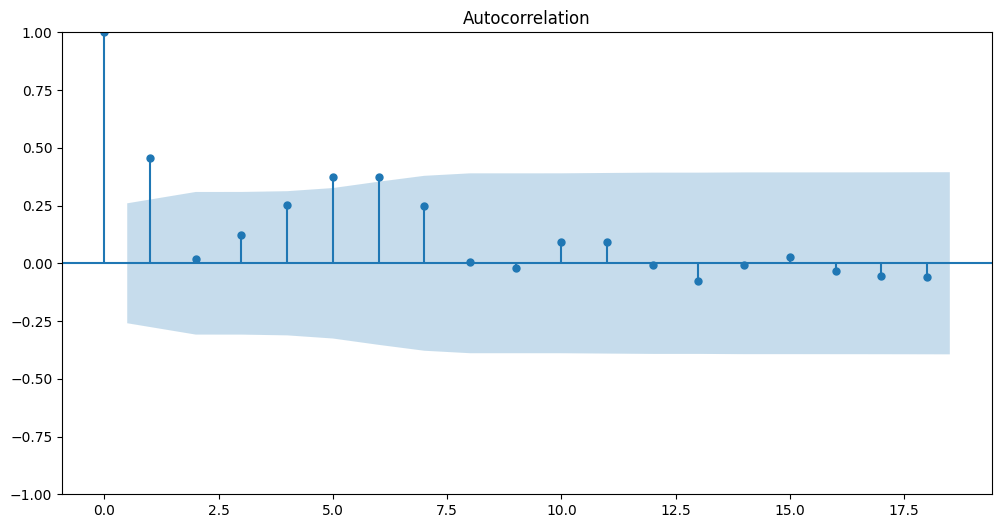

In [69]:
plt.rcParams['figure.figsize'] = 12, 6

plot_acf(data_train.diff(2).dropna())
plt.show()

Parameter q=1, since it is the last lag which is significantly different from 0.

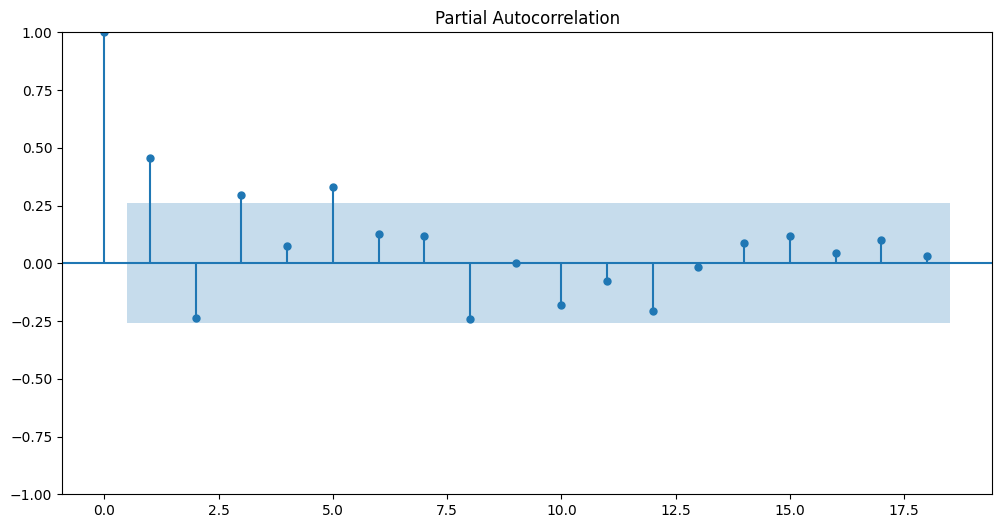

In [70]:
plot_pacf(data_train.diff(2).dropna())
plt.show()

Parameter p=1, since it is the last lag which is significantly different from 0.

Since d <> 0, we proceed with building the ARIMA model witht parameters defined as follows:
* p=1
* d=2
* q=1

In [71]:
arima_model = ARIMA(data_train['GDP (current US$)'], order=(1, 2, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1339.208
Date:                Sat, 22 Feb 2025   AIC                           2684.416
Time:                        10:07:32   BIC                           2690.545
Sample:                    01-01-1960   HQIC                          2686.798
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1775      0.082     -2.159      0.031      -0.339      -0.016
ma.L1         -0.8688      0.046    -19.069      0.000      -0.958      -0.780
sigma2       1.96e+19   2.13e-22    9.2e+40      0.000    1.96e+19    1.96e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               276.42
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):             325.65   Skew:                             1.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.34e+56. Standard errors may be unstable.
"""

### Optimize Hyperparameters

Use pmdarima to search for the optimal hyperparameters for ARIMA.

In [72]:
aamodel = pm.arima.auto_arima(
    data_train, 
    start_p=0,
    start_q=0,
    test='adf',
    max_p=5,
    max_q=5,
    d=2,
    seasonal=False,
    trace=True,
    error_action='ignore',
    suppress_warnings=True
)
aamodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2721.886, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2706.594, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2687.662, Time=0.01 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.959, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2687.339, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=2686.054, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2694.896, Time=0.01 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=2687.799, Time=0.03 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=2695.926, Time=0.01 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=2683.782, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.416, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=2693.0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.382
Date:                Sat, 22 Feb 2025   AIC                           2680.765
Time:                        10:07:33   BIC                           2690.980
Sample:                    01-01-1960   HQIC                          2684.735
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5682      0.163     -3.487      0.000      -0.888      -0.249
ma.L1         -0.4241      0.235     -1.803      0.071      -0.885       0.037
ma.L2         -0.8256      0.169     -4.886      0.000      -1.157      -0.494
ma.L3          0.5193      0.137      3.790      0.000       0.251       0.788
sigma2      1.868e+19   8.55e-21   2.18e+39      0.000    1.87e+19    1.87e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             141.34   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.07e+55. Standard errors may be unstable.
"""

Based on the pdarima modelling results the best model has the following parameters:
* p=1
* d=2
* q=3

### Prediction with Optimized Model

Let's try to make a prediction with this model.

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -1335.382
Date:                Sat, 22 Feb 2025   AIC                           2680.765
Time:                        10:07:33   BIC                           2690.980
Sample:                    01-01-1960   HQIC                          2684.735
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5682      0.163     -3.487      0.000      -0.888      -0.249
ma.L1         -0.4241      0.235     -1.803      0.071      -0.885       0.037
ma.L2         -0.8256      0.169     -4.886      0.000      -1.157      -0.494
ma.L3          0.5193      0.137      3.790      0.000       0.251       0.788
sigma2      1.868e+19   8.55e-21   2.18e+39      0.000    1.87e+19    1.87e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             141.34   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.07e+55. Standard errors may be unstable.
"""

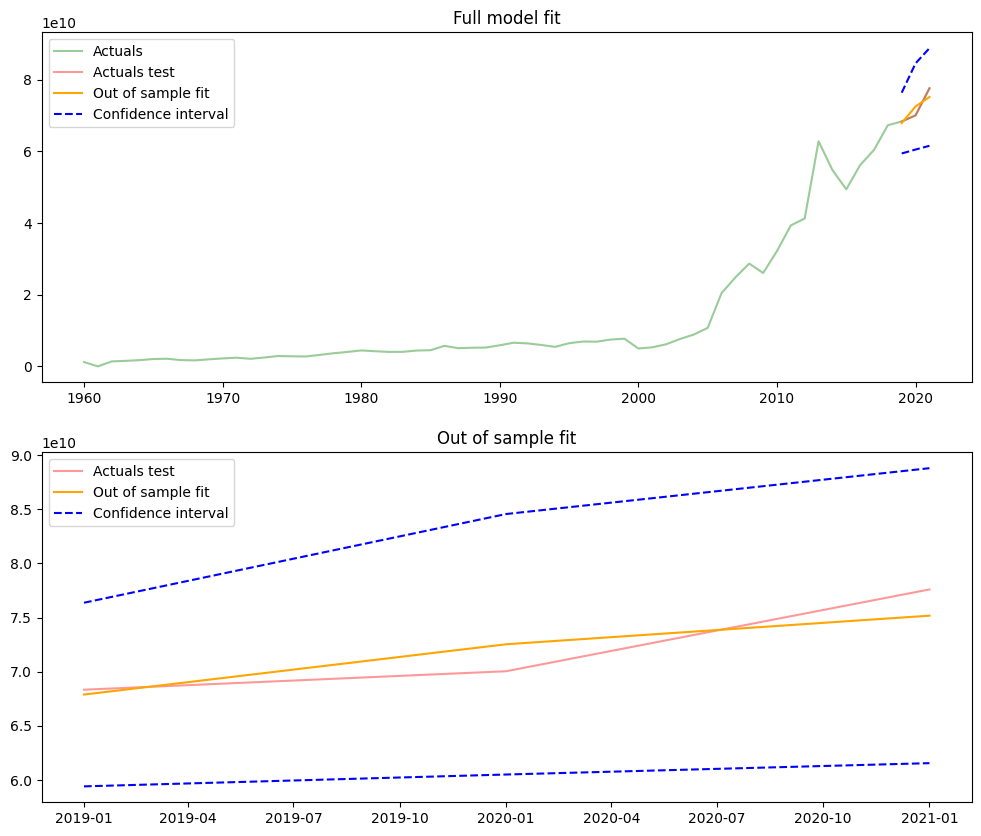

In [73]:
# Fit the model with the best parameters
arima_model = ARIMA(data_train['GDP (current US$)'], order=(1, 2, 3))
arima_model_fit = arima_model.fit()
display(arima_model_fit.summary())

# Get a prediction
data_pred = pd.DataFrame(index=data.index)
data_pred['model_preds'] = arima_model_fit.predict(start=data_test.index[0], end=data_test.index[-1])
data_pred['GDP (current US$)'] = data['GDP (current US$)']

# Get values for the confidence interval of 5 %
forecast = arima_model_fit.get_forecast(len(data_test.index))
data_forecast = forecast.conf_int(alpha=0.05)

# Add the values of the confidence interval to the results dataframe
data_pred.at[data_test.index, 'model_preds_lower'] = data_forecast['lower GDP (current US$)']
data_pred.at[data_test.index, 'model_preds_upper'] = data_forecast['upper GDP (current US$)']

# Present the results
plt.rcParams['figure.figsize'] = 12, 10
plt.subplot(2, 1, 1)
plt.plot(data_pred['GDP (current US$)'], color='green', label='Actuals', alpha=0.4)
plt.plot(data_test.loc[data_test.index]['GDP (current US$)'], color='red', label='Actuals test', alpha=0.4)
plt.plot(data_pred.loc[data_test.index]['model_preds'], color='orange', label='Out of sample fit')
plt.plot(data_pred.loc[data_test.index]['model_preds_lower'], color='blue', linestyle='--', label='Confidence interval')
plt.plot(data_pred.loc[data_test.index]['model_preds_upper'], color='blue', linestyle='--')
plt.title('Full model fit')
plt.legend()

plt.subplot(2, 1, 2)
#plt.plot(data_pred['GDP (current US$)'], color='green', label='Actuals', alpha=0.4)
plt.plot(data_test.loc[data_test.index]['GDP (current US$)'], color='red', label='Actuals test', alpha=0.4)
plt.plot(data_pred.loc[data_test.index]['model_preds'], color='orange', label='Out of sample fit')
plt.plot(data_pred.loc[data_test.index]['model_preds_lower'], color='blue', linestyle='--', label='Confidence interval')
plt.plot(data_pred.loc[data_test.index]['model_preds_upper'], color='blue', linestyle='--')
plt.title('Out of sample fit')
plt.legend()

plt.show()

The forecast caught the trend, however the original data has a downward convex, but the forecast has the upward convex.

The AIC value with not optimized parameters was 2684.416. With optimized parameters the AIC value is 2680.765. This is an improvement.

## Modelling with Interpolated Data

### Check for Gaps in Data

In [74]:
print('Number of records in dataframe:', len(data))

gaps = data.asfreq(freq='YS')
print('Number of records after gaps have been filled:', len(gaps))

Number of records in dataframe: 62
Number of records after gaps have been filled: 62


Usage of `asfreq` method did not add any records. We can conclude that there are no gaps.

### Check for Empty Values

In [75]:
print('Number of records with empty values:', data['GDP (current US$)'].isna().sum())

Number of records with empty values: 0


There are no empty values in the dataframe.

### Check for Zeroes

In [76]:
print('Records having a zero value:')
data[data['GDP (current US$)'] == 0]

Records having a zero value:


,GDP (current US$)
year,
1961-01-01,0.0


Only one record has a zero value. Let's replace it with NaN to further interpolate the value.

In [77]:
data['GDP (current US$)'] = data['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)
data.head(5)

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,NaN
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


Zero value record has been replaced with NaN.

### Interpolation

In [78]:
data_interpolated = pd.DataFrame(data['GDP (current US$)'].resample('YS').interpolate(), columns=data.columns)
data_interpolated.head(5)

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,1.299720e+09
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


The value for the year 1961 has been interpolated.

### Split Train and Test Data

In [79]:
# Take the years up to 2018 as train data. The remaining three years are taken as test data.
data_train = data_interpolated[:-3]
data_test = data_interpolated[-3:]

### Stationarity of the Interpolated Time Series

In [80]:
do_adfuller(data_train)

ADF Statistic: 0.8030073326980108
p-value: 0.9916845572455877
Critical Values:
	1%: -3.575
	5%: -2.924
	10%: -2.600


The statistics are still higher that any of the critical values. We will differentiate the data and try again.

In [81]:
do_adfuller(data_train.diff().dropna())

ADF Statistic: -1.8255652246436003
p-value: 0.36784515276563406
Critical Values:
	1%: -3.568
	5%: -2.921
	10%: -2.599


The statistics are still higher that any of the critical values. We will differentiate the data twice and try again.

In [82]:
do_adfuller(data_train.diff(2).dropna())

ADF Statistic: -3.999803440949154
p-value: 0.0014115408436661003
Critical Values:
	1%: -3.585
	5%: -2.928
	10%: -2.602


After differentiating the data twice we get a stationary time series. This means that the parameter d for ARIMA is equal to 2.

### Autocorrelation and partial autocorrelation

We proceed with building correlograms for autocorrelation and partial autocorrelation.

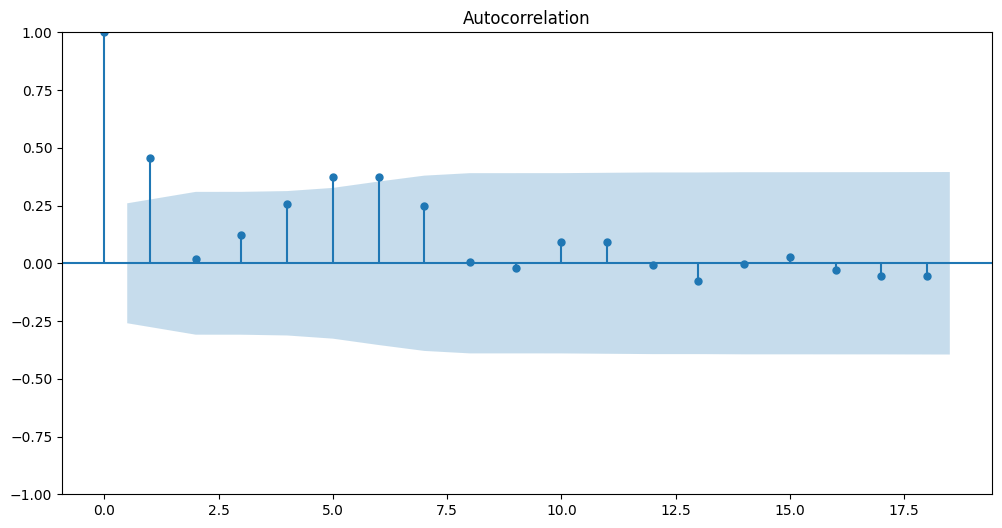

In [83]:
plt.rcParams['figure.figsize'] = 12, 6

plot_acf(data_train.diff(2).dropna())
plt.show()

Autocorrelation is not much different from the not interpolated data set. Parameter q=1, since it is the last lag which is significantly different from 0.

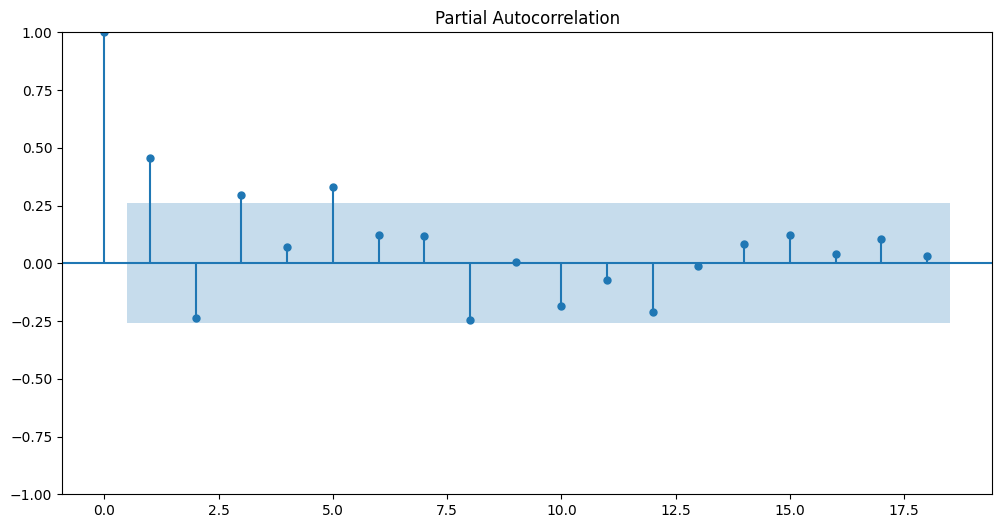

In [84]:
plot_pacf(data_train.diff(2).dropna())
plt.show()

Same as above, the different from the not interpolated data set is no significant. Parameter p=1, since it is the last lag which is significantly different from 0.

Since d <> 0, we proceed with building the ARIMA model witht parameters defined as follows:
* p=1
* d=2
* q=1

In [85]:
arima_model = ARIMA(data_train['GDP (current US$)'], order=(1, 2, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1339.188
Date:                Sat, 22 Feb 2025   AIC                           2684.377
Time:                        10:07:33   BIC                           2690.506
Sample:                    01-01-1960   HQIC                          2686.759
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1750      0.082     -2.127      0.033      -0.336      -0.014
ma.L1         -0.8690      0.046    -19.050      0.000      -0.958      -0.780
sigma2       1.96e+19   2.13e-22   9.21e+40      0.000    1.96e+19    1.96e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               277.83
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):             480.68   Skew:                             1.36
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.75e+56. Standard errors may be unstable.
"""

### Optimize Hyperparameters

Use pmdarima to search for the optimal hyperparameters for ARIMA with interpolated data.

In [86]:
aamodel = pm.arima.auto_arima(
    data_train, 
    start_p=0,
    start_q=0,
    test='adf',
    max_p=5,
    max_q=5,
    d=2,
    seasonal=False,
    trace=True,
    error_action='ignore',
    suppress_warnings=True
)
aamodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2721.621, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2706.528, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2687.799, Time=0.01 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.683, Time=0.00 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2687.479, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=2686.221, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2694.822, Time=0.01 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=2687.929, Time=0.02 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=2695.861, Time=0.01 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=2683.709, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.377, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=2692.9

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.257
Date:                Sat, 22 Feb 2025   AIC                           2680.513
Time:                        10:07:34   BIC                           2690.729
Sample:                    01-01-1960   HQIC                          2684.483
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5586      0.171     -3.271      0.001      -0.893      -0.224
ma.L1         -0.4271      0.248     -1.724      0.085      -0.913       0.059
ma.L2         -0.8246      0.185     -4.467      0.000      -1.186      -0.463
ma.L3          0.5228      0.135      3.866      0.000       0.258       0.788
sigma2      1.864e+19   1.02e-20   1.84e+39      0.000    1.86e+19    1.86e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               179.81
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             434.94   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.2e+55. Standard errors may be unstable.
"""

Based on the pdarima modelling results the best model has the following parameters:
* p=1
* d=2
* q=3

### Prediction with Optimized Model

Let's try to make a prediction with this model.

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -1335.257
Date:                Sat, 22 Feb 2025   AIC                           2680.513
Time:                        10:08:30   BIC                           2690.729
Sample:                    01-01-1960   HQIC                          2684.483
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5586      0.171     -3.271      0.001      -0.893      -0.224
ma.L1         -0.4271      0.248     -1.724      0.085      -0.913       0.059
ma.L2         -0.8246      0.185     -4.467      0.000      -1.186      -0.463
ma.L3          0.5228      0.135      3.866      0.000       0.258       0.788
sigma2      1.864e+19   1.02e-20   1.84e+39      0.000    1.86e+19    1.86e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               179.81
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             434.94   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.2e+55. Standard errors may be unstable.
"""

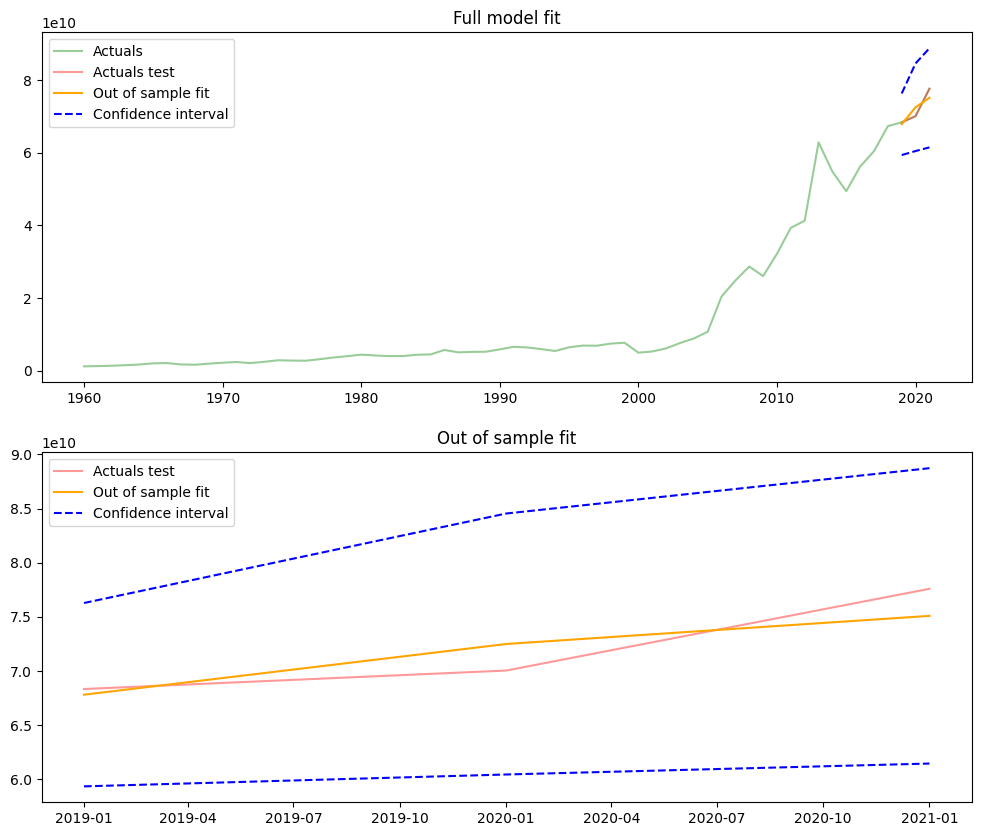

In [91]:
# Fit the model with the best parameters
arima_model = ARIMA(data_train['GDP (current US$)'], order=(1, 2, 3))
arima_model_fit = arima_model.fit()
display(arima_model_fit.summary())

# Get a prediction
data_pred = pd.DataFrame(index=data.index)
data_pred['model_preds'] = arima_model_fit.predict(start=data_test.index[0], end=data_test.index[-1])
data_pred['GDP (current US$)'] = data_interpolated['GDP (current US$)']

# Get values for the confidence interval of 5 %
forecast = arima_model_fit.get_forecast(len(data_test.index))
data_forecast = forecast.conf_int(alpha=0.05)

# Add the values of the confidence interval to the results dataframe
data_pred.at[data_test.index, 'model_preds_lower'] = data_forecast['lower GDP (current US$)']
data_pred.at[data_test.index, 'model_preds_upper'] = data_forecast['upper GDP (current US$)']

# Present the results
plt.rcParams['figure.figsize'] = 12, 10
plt.subplot(2, 1, 1)
plt.plot(data_pred['GDP (current US$)'], color='green', label='Actuals', alpha=0.4)
plt.plot(data_test.loc[data_test.index]['GDP (current US$)'], color='red', label='Actuals test', alpha=0.4)
plt.plot(data_pred.loc[data_test.index]['model_preds'], color='orange', label='Out of sample fit')
plt.plot(data_pred.loc[data_test.index]['model_preds_lower'], color='blue', linestyle='--', label='Confidence interval')
plt.plot(data_pred.loc[data_test.index]['model_preds_upper'], color='blue', linestyle='--')
plt.title('Full model fit')
plt.legend()

plt.subplot(2, 1, 2)
#plt.plot(data_pred['GDP (current US$)'], color='green', label='Actuals', alpha=0.4)
plt.plot(data_test.loc[data_test.index]['GDP (current US$)'], color='red', label='Actuals test', alpha=0.4)
plt.plot(data_pred.loc[data_test.index]['model_preds'], color='orange', label='Out of sample fit')
plt.plot(data_pred.loc[data_test.index]['model_preds_lower'], color='blue', linestyle='--', label='Confidence interval')
plt.plot(data_pred.loc[data_test.index]['model_preds_upper'], color='blue', linestyle='--')
plt.title('Out of sample fit')
plt.legend()

plt.show()

Again the forecast caught the trend, however the original data has a downward convex, but the forecast has the upward convex.

The AIC value for not interpolated data was 2680.765, for the interpolated data it is 2680.513, which is a slight improvement.